In [101]:
from IPython import embed

import myutil
import torch
from data import getds
from models import create_model
import numpy as np
from tqdm import tqdm
import copy
from data.fast_dataset import FastTXDS
from bmel.data.fastmri import FastSliceDS, FastDS

from monai.visualize import matshow3d
import matplotlib.pyplot as plt

In [2]:
RND = 42
NAME = 'fast_translate'
EPOCH_NDX = 50

opt = myutil.load_opts(NAME)
opt.phase = 'test'
opt.epoch = EPOCH_NDX
opt.num_threads = 0   # test code only supports num_threads = 0
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
opt.isTrain = False
torch.manual_seed(RND)

In [19]:
preds = torch.load('checkpoints/fast_translate/preds.pt')
for vol in preds.values():
    for k in vol:
        vol[k] = vol[k] - 0.5

In [109]:
ds = FastTXDS()
lbl_df = FastDS().df

In [113]:
lbl_df_bmel = lbl_df[lbl_df['label'] == 'BMEL']
bmel_vol_ids = lbl_df_bmel['file'].unique()

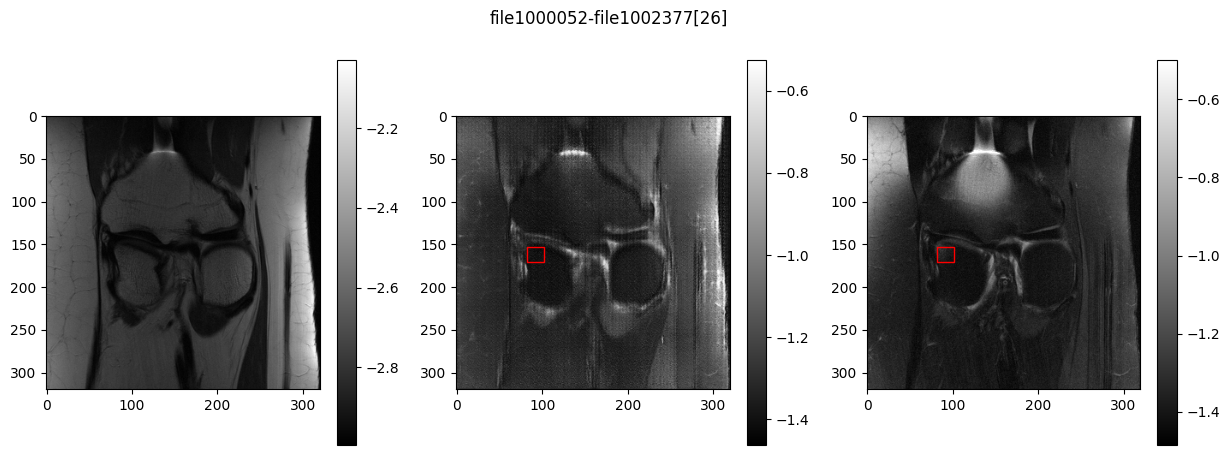

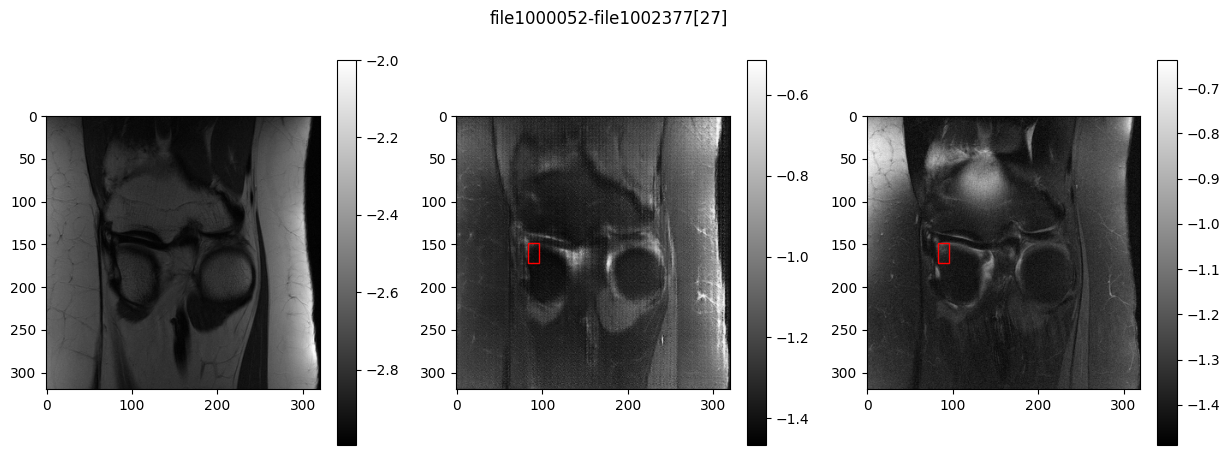

In [125]:
for id, vol in preds.items():
    id_nofs, id_fs = id.split('-')
    if id_fs not in bmel_vol_ids: continue
    slcs_bmel = lbl_df_bmel[lbl_df_bmel['file'] == id_fs]
    for _, slc_bmel in slcs_bmel.iterrows():
        slc_ndx = int(slc_bmel['slice'])
        x = slc_bmel['x']
        y = slc_bmel['y']
        width = slc_bmel['width']
        height = slc_bmel['height']

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        im = ax[0].imshow(vol['real_A'][0, slc_ndx], 'gray')
        plt.colorbar(im, ax=ax[0])
        im = ax[1].imshow(vol['fake_B'][0, slc_ndx], 'gray')
        ax[1].add_patch(plt.Rectangle((x,y), width, height, fill=False, edgecolor='r'))
        plt.colorbar(im, ax=ax[1])
        im = ax[2].imshow(vol['real_B'][0, slc_ndx], 'gray')
        ax[2].add_patch(plt.Rectangle((x,y), width, height, fill=False, edgecolor='r'))
        plt.colorbar(im, ax=ax[2])
        fig.suptitle(f'{id}[{slc_ndx}]')
        plt.show()
    break